In [82]:
%matplotlib inline

import sys
sys.path.append('/home/ngr/gdrive/wearables/scripts')
import data as weardata

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sktime, API REF: https://www.sktime.org/en/latest/api_reference.html
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.utils.data_processing import from_2d_array_to_nested
from sktime.regression.compose import ComposableTimeSeriesForestRegressor
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.classification.dictionary_based import ContractableBOSS
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

# eval
from sklearn.metrics import mean_absolute_error

# model selection
from sklearn.model_selection import KFold

In [2]:
data = weardata.get_train_test()
X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

In [36]:
# convert into sktime format, i.e., convert to dataframe, with time-series held in a column (one col per uni-variate time-series data)
X_train_df = from_2d_array_to_nested(X_train)
X_test_df = from_2d_array_to_nested(X_test)
X_train_df.head()

## exploration

Look into how many samples in training set we have for each GA (in weeks)

In [71]:
savefigs = True

In [80]:
os.path.join(os.getcwd(), '../results/')

'/mnt/c/Users/ngr4/gdrive/wearables/notebooks/../results/bla'

[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.] [  2  11  26  52  91 156  97  82  83 103  61  59  57  63  34  42  40  47
  30  43  85 159  71  27  32  40  21  29  36  86 102 167  60  43   9   1]


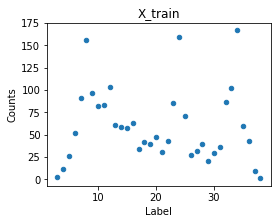

In [81]:
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

# viz
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(labels, counts, s=20)

ax.set_xlabel('Label')
ax.set_ylabel('Counts')
ax.set_title('X_train')

if savefigs:
    fig.savefig(os.path.join(os.getcwd(), '../results/scatter_countsVlabels.png'), bbox_inches='tight', dpi=600)

In [69]:
def actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, sk_modelclass, 
                      exp = 'TimeSeriesForest_GAregression', kfolds=5, 
                      verbose=True):
    '''Run sktime models on GA data
    
    TODO (ngr):
      1. add out_file storage in addition (or instead of) printing results
    '''
    if verbose:
        tic = time.time()
        print('Starting {} experiment...'.format(exp))
    models = {} # (tuple): (model, eval_criterion) where eval_criterion = MAE here

    kf = KFold(n_splits=kfolds, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(idx)):
        if verbose:
            sub_tic = time.time()
        X_train_df_cv, y_train_cv = X_train_df.iloc[train_idx, :], y_train[train_idx]
        X_val_df, y_val = X_train_df.iloc[val_idx, :], y_train[val_idx]

        # init model
        model = sk_modelclass # ComposableTimeSeriesForestRegressor()

        # fit, eval, store
        model.fit(X_train_df_cv, y_train_cv)
        mae = mean_absolute_error(y_val, model.predict(X_val_df))
        models['CV{}'.format(i)] = (model, mae)
        del model
        
        if verbose:
            print('  k={}-fold finished in {:.1f}-s\ttotal_time_elapsed: {:.1f}-min'.format(i, time.time()-sub_tic, (time.time()-tic)/60))

    # store in file
    print('\n... finished in {:.1f}-min'.format((time.time()-tic)/60))
    print('\n----')
    print('{} results:'.format(exp))
    print('  <MAE>_{}folds: {:.4f}\tSD_{}folds: {:.1f}'.format(kfolds, np.mean([v[1] for k,v in models.items()]), kfolds, np.std([v[1] for k,v in models.items()])))
    print('  MAE_test: {:.4f}'.format(mean_absolute_error(y_test, models['CV{}'.format(np.argmax([v[1] for k,v in models.items()]))][0].predict(X_test_df))))
    print('----')
    
    return models

In [ ]:
cboss = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           ContractableBOSS(time_limit=1., n_jobs=-1), 
                           exp='ContractableBOSS_GAclass')

Starting ContractableBOSS_GAclass experiment...
  k=0-fold finished in 87.4-s	total_time_elapsed: 1.5-min


In [ ]:
knndtw = actigraphy_sktime(X_train_df, y_train, X_test_df, y_test, 
                           KNeighborsTimeSeriesClassifier(n_neighbors=3, weights='distance'), 
                           exp='kNNDTW_GAclass')